# DRQN

### 기본적인 패키지 임포트

In [14]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper import *

### 환경 초기화 

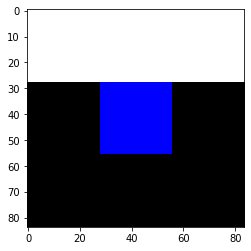

In [15]:
from gridworld import gameEnv

# partial : 부분 관찰 여부, size : gridworld의 크기
env = gameEnv(partial=False, size=9) # 크기 9의 완전 관찰 MDP
env = gameEnv(partial=True, size=9)  # 크기 9의 부분 관찰 MDP

### 네트워크 구현

In [16]:
class Qnetwork():
    # 초기화 부분
    def __init__(self, h_size, rnn_cell, myScope):
        # scalarInput 변수 설정 ( 게임에서의 하나의 프레임  21168 = 84 * 84 * 3 )
        self.scalarInput = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
        # scalarInput을 배열로 만듦 ( 프레임 -> 배열 )
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        # 합성곱 계층 설정
        self.conv1 = slim.convolution2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8,8], stride=[4,4], padding='VALID', biases_initializer=None, scope=myScope+'_conv1')
        self.conv2 = slim.convolution2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4], stride=[2,2], padding='VALID', biases_initializer=None, scope=myScope+'_conv2')
        self.conv3 = slim.convolution2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3], stride=[1,1], padding='VALID', biases_initializer=None, scope=myScope+'_conv3')
        self.conv4 = slim.convolution2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7], stride=[1,1], padding='VALID', biases_initializer=None, scope=myScope+'_conv4')
        
        # trainLength 변수 설정 ( 학습 길이 )
        self.trainLength = tf.placeholder(dtype=tf.int32)
        
        # 순환 신경망 구현
        # batch size 설정
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[])
        # RNN 처리를 위한 크기 조정 ( batch * trace * units )
        self.convFlat = tf.reshape(slim.flatten(self.conv4), [self.batch_size, self.trainLength, h_size])
        # RNN 초기 상태
        self.state_in = cell.zero_state(self.batch_size, tf.float32)
        # RNN 처리
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.convFlat, cell=rnn_cell, dtype=tf.float32, initial_state=self.state_in, scope=myScope+'_rnn')
        # 다음 계층을 위한 크기 조정
        self.rnn = tf.reshape(self.rnn, shape=[-1,h_size])

        # 듀얼링 DQN 구현
        # RNN 결과를 어드밴티지 스트림과 가치 스트림으로 분리
        self.streamA, self.streamV = tf.split(self.rnn, 2, 1)
        # AW, VW 변수 설정
        self.AW = tf.Variable(tf.random_normal([h_size//2, 4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        # 어드밴티지 스트림과 AW의 행렬곱으로 어드밴티지 계산
        self.Advantage = tf.matmul(self.streamA, self.AW)
        # 가치 스트림과 VW의 행렬곱으로 가치 계산
        self.Value = tf.matmul(self.streamV, self.VW)
        # 어드밴티지와 입력값의 그래디언트값으로 gif 생성 시 불투명도의 여부 결정
        self.salience = tf.gradients(self.Advantage, self.imageIn)
        
        # 가치 함수와 어드밴티지 함수의 조합으로 Q값 계산 ( Q = V + ( A - avg(A) ) )
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        # Q 값을 통해 행동 예측
        self.predict = tf.argmax(self.Qout, 1)
        
        # 타깃 Q 변수 설정, 액션 변수 설정, 액션의 원핫 벡터 생성
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, 4, dtype=tf.float32)
        
        # 예측 Q 계산
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        # 타깃 Q와 예측 Q의 차의 제곱합으로 오차를 구함
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # 오차의 절반을 마스크 처리
        self.maskA = tf.zeros([self.batch_size, self.trainLength//2])
        self.maskB = tf.ones([self.batch_size, self.trainLength//2])
        self.mask = tf.concat([self.maskA, self.maskB], 1)
        self.mask = tf.reshape(self.mask, [-1])
        self.loss = tf.reduce_mean(self.td_erroe*self.mask)
        
        # 최적화 설정 ( AdamOptimizer, 손실 최소화 ) 
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### 경험 리플레이
버퍼에 경험을 저장해두었다가 랜덤하게 뽑아서 네트워크 학습

In [17]:
class experience_buffer():
    # 경험 버퍼 초기화
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    # 버퍼에 경험 추가
    def add(self, experience):
        # buffer size를 넘으면 앞에서부터 지우고 추가
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
        
    # 버퍼에서 랜덤하게 경험 추출
    def sample(self, batch_size, trace_length):
        # 버퍼에서 batch size만큼 샘플 추출
        sampled_episodes = random.sample(self.buffer, batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0, len(list(episode)) + 1 - trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces, [batch_size*trace_length, 5])

### 네트워크 학습

학습 매개변수 설정

In [18]:
batch_size = 4            # 각 학습 단계에서 사용할 경험 배치의 수
trace_length = 8          # 학습 시 각 경험 추이의 길이
update_freq = 5           # 학습 단계 업데이트 빈도
y = .99                   # 타깃 Q 값에 대한 할인 계수
startE = 1                # 랜덤한 액션을 시작할 가능성
endE = 0.1                # 랜덤한 액션을 끝낼 가능성
anneling_steps = 10000    # startE에서 endE로 줄어드는 데 필요한 학습 단계 수
num_episodes = 10000      # 네트워크를 학습시킬 에피소드의 수
pre_train_steps = 10000   # 학습 시작 전 랜덤 액션의 단계 수
load_model = False       # 저장된 모델을 로드할 지 여부
path = "./drqn"           # 모델을 저장할 경로
h_size = 512              # 어드밴티지 / 가치 스트림으로 분리되기 전 마지막 합성곱 계층의 크기
max_epLength = 50         # 허용되는 최대 에피소드 길이
time_per_step = 1         # gif 생성에 사용되는 각 단계의 길이
summaryLength = 100       # 분석을 위해 주기적으로 저장할 에피소드의 수
tau = 0.001               # 타깃 네트워크를 제 1 네트워크로 업데이트하는 비율

학습 환경 설절

In [19]:
# 텐서플로 그래프 초기화
tf.reset_default_graph()

# 최초의 Q 네트워크와 타깃 Q 네트워크에 대한 RNN 셀 정의
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)
mainQN = Qnetwork(h_size, cell, 'main')
targetQN = Qnetwork(h_size, cellT, 'target')


# 텐서플로 전역 변수 초기화
init = tf.global_variables_initializer()


# 모델을 저장할 saver 정의
saver = tf.train.Saver(max_to_keep=5)


# 학습시킬 변수 선언
trainables = tf.trainable_variables()


# 타깃 Q 네트워크 업데이트하기 위한 값 설정
targetOps = updateTargetGraph(trainables, tau)


# 경험 버퍼 선언
myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율 설정
e = startE
stepDrop = (startE - endE)/anneling_steps

# 에피소드별 단계 수 리스트
jList = []
# 보상의 총계 리스트
rList = []
# 총 단계 수
total_steps = 0

# path에 해당하는 경로가 없다면 디렉토리 생성
if not os.path.exists(path):
    os.makedirs(path)
    
# 로그 파일의 첫 번째 행 작성
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(['Episode', 'Length', 'Reward', 'IMG', 'LOG', 'SAL'])

실제 학습 실행

In [ ]:
with tf.Session() as sess:
    # path에 저장된 모델 로드
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(init)
    
    # 타깃 네트워크가 제 1 네트워크와 동일하도록 설정
    updateTarget(targetOps, sess)
    
    # 에피소드 수만큼 학습 진행
    for i in range(num_episodes):
        # 경험 버퍼 초기화
        episodeBuffer = []
        
        # 환경 초기화
        sP = env.reset()
        # 새로운 관찰
        s = processState(sP)
        # 게임 종료 여부
        d = False
        # 보상의 합계
        rAll = 0
        # 단계 수
        j = 0
        
        # 순환 계층의 은닉상태 초기화
        state = (np.zeros([1,h_size]), np.zeros([1, h_size]))
        
        # 최대 에피소드 길이만큼 단계 진행 ( 최대 50회 시도 )
        while j < max_epLength:
            j += 1
            
            # e의 확률로 랜덤 액션 선택 ( greedy )
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state, feed_dict={mainQN.scalarInput:[s/255.0], mainQN.trainLength:1, 
                                                               mainQN.state_in:state, mainQN.batch_size:1})
                a = np.random.randint(0, 4)
            else:
                a, state1 = sess.run([mainQN.predict, mainQN.rnn_state], 
                                     feed_dict={mainQN.scalarInput:[s/255.0], mainQN.trainLength:1, 
                                                mainQN.state_in:state, mainQN.batch_size:1})
                a = a[0]
                
            # 선택된 액션 진행 ( 상태, 보상, 종료 여부 )
            s1P, r, d = env.step(a)
            # 상태에 따른 관찰
            s1 = processState(s1P)
            # 총 단계 증가
            total_steps += 1
            # 에피소드 버퍼에 에피소드 추가 ( 상태, 액션, 보상, 다음 상태, 종료 여부 )
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]), [1,5]))
            
            # 총 단계 수가 랜덤 액션 단계수보다 크면 랜덤 액션 가능성 조절 및 네트워크 업데이트
            if total_steps > pre_train_steps:
                # 랜덤 액션 가능성 조절
                if e > endE:
                    e -= stepDrop
                
                # 설정한 빈도수에 맞게 네트워크 업데이트
                if total_steps % (update_freq) == 0:
                    # 타깃 네트워크 업데이트
                    updateTarget(targetOps, sess)
                    # 순환 계층의 은닉상태 초기화
                    state_train = (np.zeros([batch_size, h_size]), np.zeros([batch_size, h_size]))
                    # 경험에서 랜덤한 배치 샘플링
                    trainBatch = myBuffer.sample(batch_size, trace_length)
                    # 타깃 Q 갑셍 대해 더블 DQN 업데이트 수행
                    # 액션 예측 값
                    Q1 = sess.run(mainQN.predict, 
                                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0), 
                                             mainQN.trainLength:trace_length, 
                                             mainQN.state_in:state_train, mainQN.batch_size:batch_size})
                    # 타깃 네트워크의 Q 값
                    Q2 = sess.run(targetQN.Qout, 
                                  feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0), 
                                             targetQN.trainLength:trace_length, 
                                             targetQN.state_in:state_train, targetQN.batch_size:batch_size})
                    # 종료 여부에 따른 라벨
                    end_multiplier = -(trainBatch[:,4] - 1)
                    # 더블 Q 값 구하기
                    doubleQ = Q2[range(batch_size*trace_length), Q1]
                    # 타깃 Q 값 구하기
                    targetQ = trainBatch[:,2] + (y*doubleQ*end_multiplier)
                    
                    # 제 1 네트워크 업데이트
                    sess.run(mainQN.updateModel, 
                             feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0), mainQN.targetQ:targetQ, 
                                        mainQN.actions:trainBatch[:,1], mainQN.trainLength:trace_length, 
                                        mainQN.state_in:state_train, mainQN.batch_size:batch_size})
            # 총 보상 업데이트
            rAll += r
            # 상태 전환 ( 다음 상태로 이동 )
            s = s1
            sP = s1P
            state = state1
            
            if d == True:
                break
        
        # 경험 버퍼에 에피소드 추가
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        myBuffer.add(episodeBuffer)
        # 보상 총계와 단계 수 업데이트
        jList.append(j)
        rList.append(rAll)
        
        # 주기적으로 모델 저장
        if i % 1000 == 0 and i != 0:
            saver.save(sess, path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print(total_steps, np.mean(rList[-summaryLength:]), e)
            saveToCenter(i, rList, jList, np.reshape(np.array(episodeBuffer), [len(episodeBuffer), 5]), 
                         summaryLength, h_size, sess, mainQN, time_per_step)
    saver.save(sess, path+'/model-'+str(i)+'.cptk')

### 네트워크 테스트

테스트 매개변수 설정

In [ ]:
e = 0.01               # 랜덤 액션 선택 가능성
num_episodes = 10000   # 에피소드 개수
load_model = True     # 저장한 모델 로드 여부
path = "./drqn"       # 로드 / 저장할 모델 경로
h_size = 512          # 은닉계층 크기
max_epLength = 50     # 최대 에피소드 길이
time_per_step = 1     # 각 단계의 길이 ( gif 생성 시 사용 )
summaryLength = 100   # 분석을 위해 주기적으로 저장할 에피소드의 수

테스트 실행

In [ ]:
# 텐서플로 그래프 초기화
tf.reset_default_graph()

# 최초의 Q 네트워크와 타깃 Q 네트워크에 대한 RNN 셀 정의
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size, state_is_tuple=True)

# 제 1 네트워크와 타깃 네트워크 생성
mainQN = Qnetwork(h_size, cell 'main')
targetQN = Qnetwork(h_size, cellT, 'target')

# 텐서플로 전역 변수 초기화
init = tf.global_variables_initializer()

# 모델을 저장할 saver 정의
saver = tf.train.Saver(max_to_keep=2)

# 에피소드별 단계 수 리스트
jList = []
# 보상의 총계 리스트
rList = []
# 총 단계 수
total_steps = 0

# path에 해당하는 경로가 없다면 디렉토리 생성
if not os.path.exists(path):
    os.makedirs(path)
    
# 로그 파일의 첫 번째 행 작성
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(['Episode', 'Length', 'Reward', 'IMG', 'LOG', 'SAL'])
    
# 테스트 실행
with tf.Session() as sess:
    # path에 저장된 모델 로드
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        sess.run(init)
        
    # 에피소드 수만큼 테스트 진행
    for i in range(num_episodes):
        # 경험 버퍼 초기화
        episodeBuffer = []
        
        # 환경 초기화
        sP = env.reset()
        # 새로운 관찰
        s = processState(sP)
        # 게임 종료 여부
        d = False
        # 보상의 합계
        rAll = 0
        # 단계 수
        j = 0
        
        # 순환 계층의 은닉상태 초기화
        state = (np.zeros([1, h_size]), np.zeros([1, h_size]))
        
        # 최대 에피소드 길이만큼 단계 진행 ( 최대 50회 시도 )
        while j < max_epLength:
            j += 1
            
            # e의 확률로 랜덤 액션 선택
            if np.random.rand(1) < e:
                state1 = sess.run(mainQN.rnn_state, feed_dict={mainQN.scalarInput:[s/255.0], mainQN.trainLength:1, 
                                                              mainQN.state_in:state, mainQN.batch_size:1})
                a = np.random.randint(0, 4)
            else:
                a, state1 = sess.run([mainQN.predict, mainQN.rnn_state], feed_dict={mainQN.scalarInput:[s/255.0], 
                                                                                    mainQN.trainLength:1, 
                                                                                    mainQN.state_in:state, mainQN.batch_size:1})
                a = a[0]
            
            # 선택된 액션 진행 ( 상태, 보상, 종료 여부 )
            s1P, r, d = env.step(a)
            # 상태에 따른 관찰
            s1 = processState(s1P)
            # 총 단계 증가
            total_steps += 1
            
            # 에피소드 버퍼에 에피소드 추가 ( 상태, 액션, 보상, 다음 상태, 종료 여부 )
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            # 총 보상 업데이트
            rAll += r
            # 상태 전환 ( 다음 상태로 이동 )
            s = s1
            sP = s1P
            state = state1
            if d == True:
                break
                
        bufferArray = np.array(episodeBuffer)
        # 보상 총계와 단계 수 업데이트
        jList.append(j)
        rList.append(rAll)
        
        # 주기적으로 모델 저장
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print(total_steps, np.mean(rList[-summaryLength:]), e)
            saveToCenter(i, rList, jList, np.reshape(np.array(episodeBuffer), [len(episodeBuffer),5]), 
                         summaryLength, h_size, sess, mainQN, time_per_step)
            
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes))